In [4]:
source('helpers.R')

In [5]:
# BiocManager::install("homologene")
library(homologene)

In [2]:
ip <- readRDS("../../../ProcessedData/seurat/clustered_ip4.rds")
prepost <- readRDS("../../../ProcessedData/seurat/annotated_prepost_csf.rds")

In [10]:
prepost <- subset(prepost, Patient %in% unique(ip$Patient))

In [11]:
merged <- merge(prepost, y = ip)

In [13]:
merged$source <- 'CSF'
merged$source[merged$Day == 'IP'] <- 'IP'

In [15]:
merged$source_cell_type <- paste0(merged$source, '_', merged$cell_type)

In [18]:
merged_CD8s <- subset(merged, source_cell_type %in% c('CSF_CD8+ CAR T','IP_CD8+ T'))

In [19]:
merged_CD8s@meta.data$CAR_Transcript = 'CAR -'
merged_CD8s@meta.data$CAR_Transcript[GetAssayData(merged_CD8s, layer='count')['CAR',] > 0]  = 'CAR +'

In [20]:
merged_CD8CARpos <- subset(merged_CD8s, CAR_Transcript=='CAR +')

In [ ]:
saveRDS(merged_CD8CARpos, "../../../ProcessedData/seurat/csf_and_ip_cd8s.rds")

In [21]:
# https://www.cell.com/cms/10.1016/j.immuni.2007.09.006/attachment/b2c2a30c-7327-4980-bb36-1c5b83f5e31d/mmc1.pdf
# Wherry et al., Immunity 27, Supplemental Table 2
wherry_tex_vs_teff <- c(
  # I. Inhibitory receptors
  "Cd244", "Pdcd1", "Ctla4", "Gp49b", "Ptger4", "Cd160", "Lag3", "Ptger2",
  # II. Cell-surface receptors & ligands
  "Cd7", "Tnfrsf9", "Glycop", "Vcam1", "Tnfsf6", "Itm2a", "Mox2", "Itgav", "Cd9",
  # III. Homing & migration
  "Ccl3", "Cxcr4", "Ccl4", "Ccrl2",
  # VI. TGF-β pathway
  "Smad1",
  # VIII. Signaling
  "Rgs16", "Gpr56", "Tank", "Dusp1", "Gpr65", "Ptpn13", "Prkwnk", "Il6st", "Itpr5",
  "Jak3", "Map3k1", "Sh2d2a", "Socs3",
  # IX. Cytoskeleton
  "Actn1",
  # X. IFN response
  "Isg20", "G1p2", "Icsbp1",
  # XI. Proteases
  "Serpina",
  # XII. Antigen receptors
  "Tcrg-V4", "Tcrb-V1",
  # XIV. Transcription
  "Pbx3", "Eomes", "Atf1", "Ahr", "Egr2", "Nfatc1", "Zfp91", "Hist1h2",
  # XV. Apoptosis / annexins
  "Bcl2", "Casp3",
  # XVI. Membrane biology & vesicle transport
  "Plscr1",
  # XVII. Cell cycle
  "Gas2", "Cks2",
  # XVIII. Metabolism
  "Car2", "Slc12a2", "Art3", "Gpd2", "Ndufa5", "Cyp4v3", "Entpd1", "C76628",
  # XIX. Translation
  "Sfrs7",
  # XX. Miscellaneous
  "Mtv43", "C79248", "Penk1", "Coch", "Nr4a2", "A43010", "Ier5", "Septin",
  "Rcn", "Wbp5", "Pbef1", "Ppm1b", "Ddit4", "Kitl", "Trim47", "Rnf11",
  "Nrip1", "Tubb2", "Spp1", "Klk6", "Ly75", "Slc2a1", "Bub1", "Ndfip1",
  "Spred2", "Cbx4", "Tagln2", "Hint1", "Lef1", "Lsp1", "Tob1"
)


In [22]:
hh <- mouse2human(wherry_tex_vs_teff)
wherry_tex_vs_teff_human <- unique(hh$humanGene)

In [23]:
pace_cytox <- c(
  "S1PR5","KLRK1","CD244","GZMA","ANXA1","CX3CR1","KLRG1","ZEB2","CCL9","KLRC1",
  "IL1RL1","KLRA9","LXN","ITGB2","SNX10","LAG3","S100A4","ISG20","TBX21","RORA",
  "PRF1","LYN","IFNG","ID2","IFITM3","S100A10","CCR2","PERP","NRP1","S100A6",
  "ITGAX","SQLE","ITGA4","LSP1","ADAM8","S100A8","BHLHE40","PDCD1","ANXA2","BATF3",
  "BRCA1","CASP3","CD99","EZH2","IRF4","LITAF","MPEG1","PRDX4","RHD","SNX3",
  "IGSF10","SERPINB9","PRDM1","ANXA1","SIVA1","GZMB","LGALS1","ATPIF1","CD48","SUZ12",
  "F2RL3","TK1","LGALS3","CBX1","VPS45","LMNB1","BIRC5","ANXA4"
)

In [24]:
merged_CD8CARpos <- AddModuleScore_UCell(merged_CD8CARpos, features = list(wherry_exhaust = wherry_tex_vs_teff_human), ncores = 1, name='')

Warning message:
"The following genes were not found and will be
                        imputed to exp=0:
* CCL3L3,GPR56,WBP5"


In [25]:
merged_CD8CARpos <- AddModuleScore_UCell(merged_CD8CARpos, features = list(pace_cytox = pace_cytox), ncores = 1, name='')

Warning message:
"The following genes were not found and will be
                        imputed to exp=0:
* CCL9,KLRA9,ATPIF1"


In [26]:
merged_CD8CARpos$Day <- factor(merged_CD8CARpos$Day, levels = c('IP','D7','D21'))

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


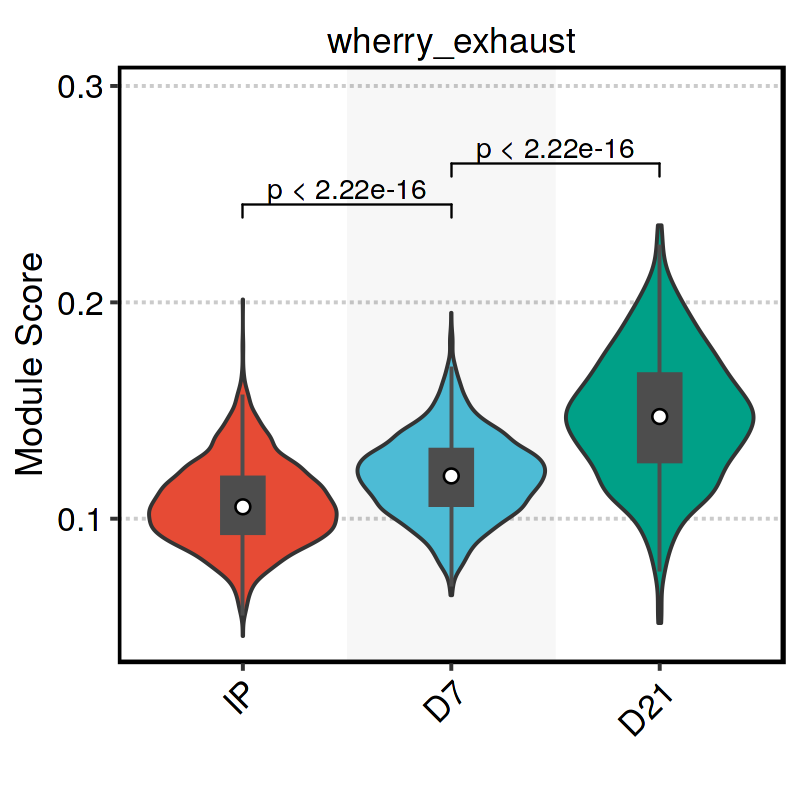

In [27]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)
p <- FeatureStatPlot(merged_CD8CARpos, group.by = "Day", ncol=4, #y.min=0.14, y.max=0.36,
                stat.by = c('wherry_exhaust'), palette='npg', add_box=T, box_color = "grey30", box_width = 0.2, 
                box_ptsize = 2, plot_type='violin', comparisons=list(c(1,2), c(2,3)), sig_label="p.format", 
                add_point=F, pt.size=0, pt.alpha=1)  &
    xlab('') & ylab('Module Score')& #ylim(0.17,0.28) & 
   NoLegend()
p

In [28]:
pdf(file.path(panel.path, paste0("cd8_ip_wherry_exhaust.pdf")), width=4, height=4)
p
dev.off()

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


pdf 
  2

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


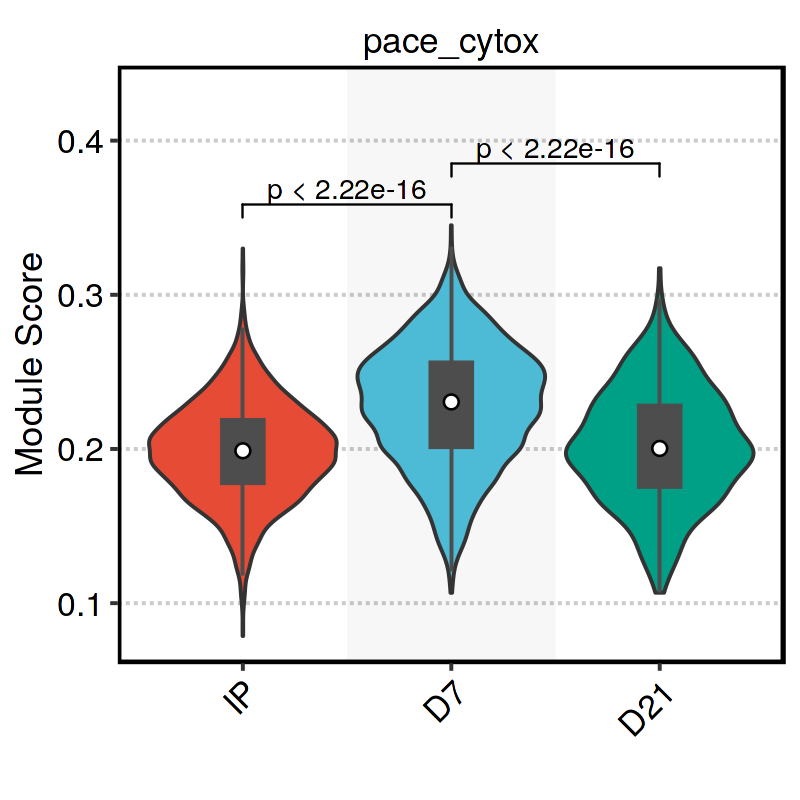

In [37]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)
p <- FeatureStatPlot(merged_CD8CARpos, group.by = "Day", ncol=4, 
                stat.by = c('pace_cytox'), palette='npg', add_box=T, box_color = "grey30", box_width = 0.2, 
                box_ptsize = 2, plot_type='violin', comparisons=list(c(1,2), c(2,3)), sig_label="p.format", 
                add_point=F, pt.size=0, pt.alpha=1)  &
    xlab('') & ylab('Module Score') 
   NoLegend()
p

In [31]:
pdf(file.path(panel.path, paste0("cd8_ip_pace_cytox.pdf")), width=4, height=4)
p
dev.off()

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


pdf 
  2